In [55]:
import pandas as pd
import numpy as np
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

In [56]:
train = pd.read_csv("train_aft.csv")
test = pd.read_csv("test_aft.csv")

train = train.drop(columns=["AFT", "COX"])
test = test.drop(columns=["AFT", "COX"])

# train["time_frame"] = train["time_frame"] / 12
# test["time_frame"] = test["time_frame"] / 12

y_train = Surv.from_dataframe("GRF_STAT_PA", "time_frame", train)
y_test = Surv.from_dataframe("GRF_STAT_PA", "time_frame", test)

X_train = train.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)
X_test = test.drop(columns=["GRF_STAT_PA", "time_frame"], axis=1)

In [57]:
rsf = RandomSurvivalForest(n_estimators=150, max_depth=8, max_features="sqrt", min_samples_leaf=3, min_samples_split=3, bootstrap=True, verbose=1, n_jobs=-1, random_state=42)

In [58]:
weights = np.where(y_train["GRF_STAT_PA"] == 1, 3.0, 1.0)  # Event: 2x weight, Censored: 1x weight

In [59]:
rsf.fit(X_train, y_train, sample_weight=weights)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.3s finished


RandomSurvivalForest(max_depth=8, min_samples_split=3, n_estimators=150,
                     n_jobs=-1, random_state=42, verbose=1)

In [60]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   24.8s finished


0.6679796977262871

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   16.6s finished


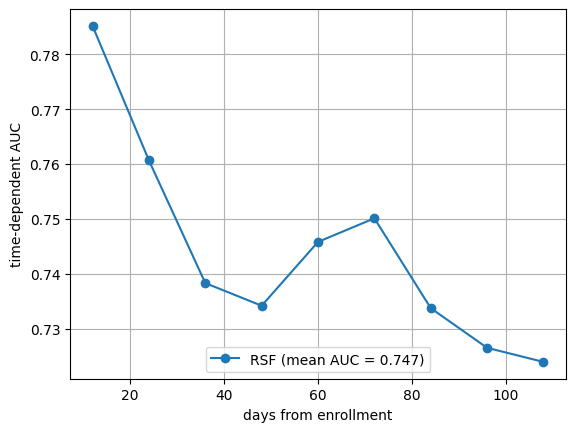

In [61]:
import matplotlib.pyplot as plt
from sksurv.metrics import cumulative_dynamic_auc



y_train = pd.DataFrame(y_train, columns=["GRF_STAT_PA", "time_frame"])
y_test = pd.DataFrame(y_test, columns=["GRF_STAT_PA", "time_frame"])

y_train["GRF_STAT_PA"] = y_train["GRF_STAT_PA"].astype("bool")
y_test["GRF_STAT_PA"] = y_test["GRF_STAT_PA"].astype("bool")

# Prepare survival objects for train and test data
y_test_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_test)
y_train_surv = Surv.from_dataframe("GRF_STAT_PA", "time_frame", data=y_train)


times = np.arange(12, 12*10, 12)

rsf_scores = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_surv = np.vstack([chf(times) for chf in rsf_scores])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_surv, times)


plt.plot(times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)




In [62]:
from sksurv.metrics import integrated_brier_score, brier_score
import numpy as np

# Define the time points at which to compute the Brier score
surv_funcs = rsf.predict_survival_function(X_test)

times_2 = np.arange(12, 12*10, 12)

# Convert survival functions into probabilities at specific time points
preds_ibs = np.asarray([[fn(t) for t in times_2] for fn in surv_funcs])


# Compute Brier Score at specific times
brier_scores = brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Brier Scores: {brier_scores}")

# Compute the Integrated Brier Score (IBS) over the specified time points
ibs = integrated_brier_score(y_train_surv, y_test_surv, preds_ibs, times_2)
print(f"Integrated Brier Score (IBS): {ibs}")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   15.6s finished


Brier Scores: (array([ 12,  24,  36,  48,  60,  72,  84,  96, 108]), array([0.01902868, 0.02744808, 0.04136655, 0.04928739, 0.05603251,
       0.06430989, 0.07249615, 0.08605261, 0.09125869]))
Integrated Brier Score (IBS): 0.05651710833812363


In [63]:
from sklearn.inspection import permutation_importance

In [64]:
perm_imp = permutation_importance(rsf, X_test, y_test_surv, n_repeats=5)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   23.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   23.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   23.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_job

In [65]:
perm_mean = pd.DataFrame(perm_imp["importances_mean"])
perm_std = pd.DataFrame(perm_imp["importances_std"])
perm_cols = pd.DataFrame(X_test.columns)

In [66]:
perm_df = pd.concat([perm_cols, perm_mean, perm_std], axis=1)

In [67]:
perm_df.columns = ["var", "mean", "std"]

In [68]:
perm_df["perm_rvi"] = perm_df["mean"] / sum(perm_df["mean"])

In [69]:
perm_df["rvi_dumb"] = perm_df["mean"] / max(perm_df["mean"])

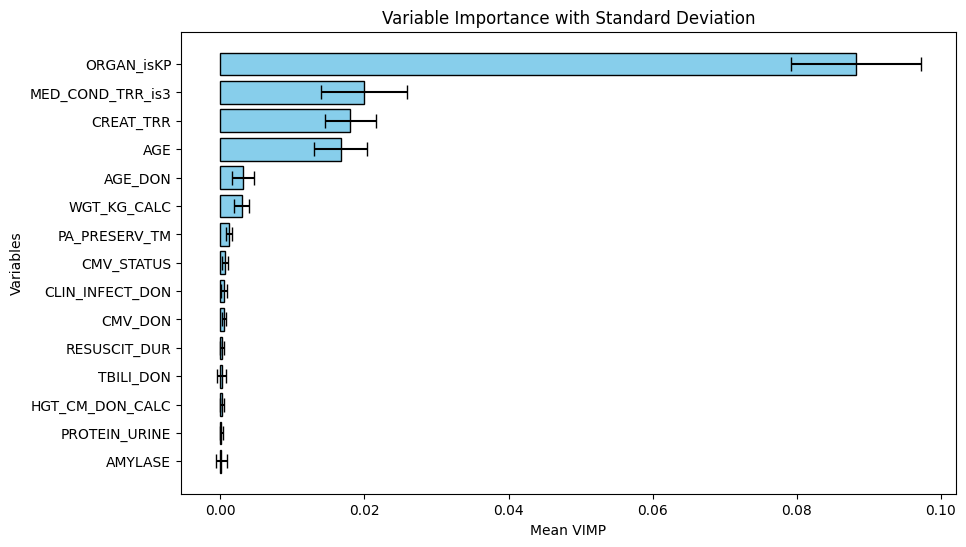

In [70]:
import matplotlib.pyplot as plt

# Sort by mean VIMP for better visualization
df = perm_df.sort_values(by="mean", ascending=False).head(15)

# Plot with error bars
plt.figure(figsize=(10, 6))
plt.barh(df["var"], df["mean"], xerr=df["std"], capsize=5, color="skyblue", edgecolor="black")
plt.xlabel("Mean VIMP")
plt.ylabel("Variables")
plt.title("Variable Importance with Standard Deviation")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [71]:
df

,var,mean,std,perm_rvi,rvi_dumb
18,ORGAN_isKP,0.088225,0.009006,0.621915,1.000000
22,MED_COND_TRR_is3,0.019917,0.005924,0.140397,0.225750
1,CREAT_TRR,0.018050,0.003589,0.127238,0.204592
13,AGE,0.016698,0.003635,0.117709,0.189268
2,AGE_DON,0.003163,0.001552,0.022297,0.035853
24,WGT_KG_CALC,0.002954,0.001009,0.020825,0.033485
15,PA_PRESERV_TM,0.001199,0.000478,0.008454,0.013593
21,CMV_STATUS,0.000654,0.000407,0.004611,0.007415
9,CLIN_INFECT_DON,0.000500,0.000439,0.003524,0.005667
4,CMV_DON,0.000468,0.000284,0.003297,0.005302
